# The Battle of Neighborhoods

### Introduction/Business Problem

Toronto is the fourth largest city in North America and the (multi)cultural centre of Canada. The city has become an incredibly diverse melting pot for food and drink culture driven by individuals inspired to share their traditions and ideas. But in a city that prides itself on its eclectic offerings, there is one industry that has been a bit late to the party: coffee. In a province that is dominated by large coffee chains, enforcing notions of convenience over quality, it has been difficult to convert this coffee-drinking populace into specialty coffee consumers. The average customer has no problem spending a premium on a higher quality meal or a higher quality beer but has hesitated to try out the shop around the corner serving single-origin espressos and handmade pour-overs.

So as part of this project , we will list and visualize all major parts of Toronto that has great Coffee shops.


### Data

For this project we need the following data:

* Toronto data that contains list of Boroughs, Neighborhoods.

 **Data source:** https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
 
 **Description:** This data set contains the required information. And we will use this data set to explore various neighborhoods of Toronto.

* Coffee Shop in each neighborhood of Toronto.

 **Data source:** Foursquare API
 
 **Description:** Foursquare is a location data provider with information about all manner of venues and events within an area of interest. Such information includes venue names, locations, menus and even photos. As such, the foursquare location platform will be used as the sole data source since all the stated required information can be obtained through the API. After finding the list of neighborhoods, we then connect to the Foursquare API to gather information about venues inside each and every neighborhood.
The data retrieved from Foursquare contained information of venues within a specified distance of the longitude and latitude of the postcodes.

* GeoSpace data

 **Data source:** https://raw.githubusercontent.com/jasonicarter/toronto-geojson/master/toronto_crs84.geojson
 
 **Description:** By using this geo space data we will get the Toronto Borough boundaries that will help us visualize choropleth map.


### Approach 

We will web scraping  the Toronto data from Wikipedia and using FourSquare API we will find all venues for each neighborhood. Next step is filter out all venues that are Coffee Shops and find rating, tips and like count for each Coffee Shop using FourSquare API. Using rating for each Coffee Shop, we will sort that data and visualize the Ranking of neighborhoods using folium library.

### Questions

* What is the best location in Toronto for have a coffee ?
* Which areas have potential Coffee Shop Market?
* Which areas lack Coffee Shops ?
* Which is the best borough to stay if I want have a coffee?
* Which is the best Coffee Shop in Toronto?
* Which Coffee Shop is rated highest in Toronto?


### Preprocessing - Data collection

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    altair-3.1.0               |           py36_0         724 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be 

In [58]:
# Data collection of Toronto
path = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M' #link to extract
df_wiki = pd.read_html(path) #read file
type(df_wiki) # type - list

neighborhoods = df_wiki[0] # Call the position where the table is stored
neighborhoods.rename(columns={0:'Postcode', 1:'Borough', 2:'Neighborhood'}, inplace=True) # rename the columns
neighborhoods.drop([0]) # Drop the first row
neighborhoods = neighborhoods[neighborhoods.Borough != 'Not assigned'] # Drop the rows that contains "Not assigned" values from Borough column
neighborhoods = pd.DataFrame(neighborhoods) # Transform in Dataframe

#Merging rows with same Postcode
neighborhoods.set_index(['Postcode', 'Borough'], inplace=True)
marge_result = neighborhoods.groupby(['Postcode', 'Borough'], sort=False).agg(','.join)
neibor = marge_result.reset_index()
neibor.loc[4, 'Neighbourhood'] = "Queen's Park" # 

neibor.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True) # Rename the column with a defect - Neighbourhood for Neighborhood 
#neibor.to_csv('borough.csv') # Saving file for futere use
df=pd.DataFrame(neibor)
df.head()

Postcode           Borough                     Neighborhood
0      M3A        North York                        Parkwoods
1      M4A        North York                 Victoria Village
2      M5A  Downtown Toronto         Harbourfront,Regent Park
3      M6A        North York  Lawrence Heights,Lawrence Manor
4      M7A      Queen's Park                     Queen's Park

In [59]:
df.shape

(103, 3)

In [60]:
# Geographical coordinates
df_lat_lon = pd.read_csv("http://cocl.us/Geospatial_data")

# Change the name of the columns
df_lat_lon.rename(columns={'Postal Code': 'Postcode'}, inplace=True)

#Merge the Latitude and the Longitude with the previous table
Toronto_df = pd.merge(df, df_lat_lon[['Postcode', 'Latitude', 'Longitude']], on='Postcode')
Toronto_df = Toronto_df.drop(['Postcode'], axis=1) # Drop Postcode column
Toronto_df.head(12)

Borough                                       Neighborhood  \
0         North York                                          Parkwoods   
1         North York                                   Victoria Village   
2   Downtown Toronto                           Harbourfront,Regent Park   
3         North York                    Lawrence Heights,Lawrence Manor   
4       Queen's Park                                       Queen's Park   
5          Etobicoke                                   Islington Avenue   
6        Scarborough                                      Rouge,Malvern   
7         North York                                    Don Mills North   
8          East York                     Woodbine Gardens,Parkview Hill   
9   Downtown Toronto                            Ryerson,Garden District   
10        North York                                          Glencairn   
11         Etobicoke  Cloverdale,Islington,Martin Grove,Princess Gar...   

     Latitude  Longitude  
0   43.753259 -79.329656  
1   43.725882 -79.315572  
2   43.654260 -79.360636  
3   43.718518 -79.464763  
4   43.662301 -79.389494  
5   43.667856 -79.532242  
6   43.806686 -79.194353  
7   43.745906 -79.352188  
8   43.706397 -79.309937  
9   43.657162 -79.378937  
10  43.709577 -79.445073  
11  43.650943 -79.554724

In [61]:
# the size of boroughs and neighborhoods
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
       len(Toronto_df['Borough'].unique()),
       len(Toronto_df['Neighborhood'].unique())
      )
     )

The dataframe has 11 boroughs and 103 neighborhoods.


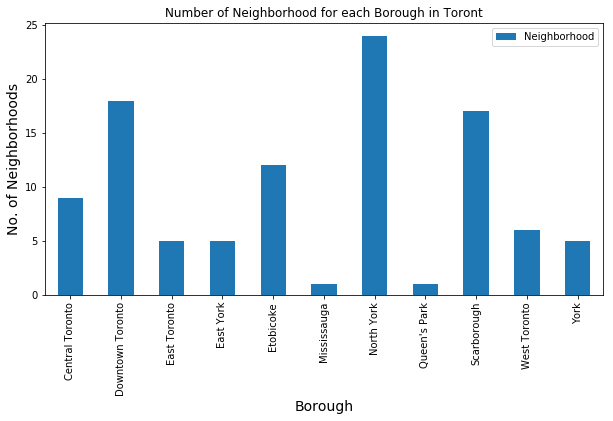

In [62]:
# Analysing the data
Toronto_df.groupby('Borough')['Neighborhood'].count().plot(kind='bar', figsize=(10,5))

# tittle
plt.title('Number of Neighborhood for each Borough in Toront')

#x-axis
plt.xlabel('Borough', fontsize = 14)

#y-axis
plt.ylabel('No. of Neighborhoods', fontsize = 14)

#Legend
plt.legend()

#Displays the bar plot
plt.show()

We see that the three biggest boroughs are Scarborough, Downtown Toronto and North York.
With North York having the most neighborhoods.


### Functions 

In [155]:
# function for get geo location of address
def geo_location(address):
    geolocator = Nominatim(user_agent="Toronto")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude
    

In [64]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '3YTT12SQVOZJEY5ZNWAZIKMUO22ZWS0TQ2VHSNRKWYUGVSRI' # your Foursquare ID
    CLIENT_SECRET = 'WC3QXOA3AGB0RWAXU0CH20VCWYHWFCARXHBKEUNQJKULDYBP' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [65]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '3YTT12SQVOZJEY5ZNWAZIKMUO22ZWS0TQ2VHSNRKWYUGVSRI' # your Foursquare ID
    CLIENT_SECRET = 'WC3QXOA3AGB0RWAXU0CH20VCWYHWFCARXHBKEUNQJKULDYBP' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Methodology

Now we will colect Coffee shop for each Neighborhoods

In [66]:
# prepare neighborhood list that contains Coffee Shop
column_names = ['Borough', 'Neighborhood', 'ID','Name']
coffee_shop = pd.DataFrame(columns=column_names)
count=1
for row in Toronto_df.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    coffee_shop_to=venues[venues['Category']=='Coffee Shop']   
    print('(',count,'/',len(Toronto_df),')','Coffee Shop in '+Neighborhood+', '+Borough+':'+str(len(coffee_shop_to)))
    for resturant_detail in coffee_shop_to.values.tolist():
        id, name , category=resturant_detail
        coffee_shop = coffee_shop.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Coffee Shop in Parkwoods, North York:1
( 2 / 103 ) Coffee Shop in Victoria Village, North York:2
( 3 / 103 ) Coffee Shop in Harbourfront,Regent Park, Downtown Toronto:15
( 4 / 103 ) Coffee Shop in Lawrence Heights,Lawrence Manor, North York:3
( 5 / 103 ) Coffee Shop in Queen's Park, Queen's Park:9
( 6 / 103 ) Coffee Shop in Islington Avenue, Etobicoke:0
( 7 / 103 ) Coffee Shop in Rouge,Malvern, Scarborough:2
( 8 / 103 ) Coffee Shop in Don Mills North, North York:3
( 9 / 103 ) Coffee Shop in Woodbine Gardens,Parkview Hill, East York:2
( 10 / 103 ) Coffee Shop in Ryerson,Garden District, Downtown Toronto:7
( 11 / 103 ) Coffee Shop in Glencairn, North York:2
( 12 / 103 ) Coffee Shop in Cloverdale,Islington,Martin Grove,Princess Gardens,West Deane Park, Etobicoke:0
( 13 / 103 ) Coffee Shop in Highland Creek,Rouge Hill,Port Union, Scarborough:0
( 14 / 103 ) Coffee Shop in Flemingdon Park,Don Mills South, North York:3
( 15 / 103 ) Coffee Shop in Woodbine Heights, East York:3
( 16

In [67]:
coffee_shop.head()

Borough              Neighborhood                        ID  \
0        North York                 Parkwoods  4b87107cf964a5207fae31e3   
1        North York          Victoria Village  4bbe904a85fbb713420d7167   
2        North York          Victoria Village  4b609d8df964a52068f029e3   
3  Downtown Toronto  Harbourfront,Regent Park  53b8466a498e83df908c3f21   
4  Downtown Toronto  Harbourfront,Regent Park  57cd9d20498e6ab8342980e2   

            Name  
0       La Notre  
1    Tim Hortons  
2    Tim Hortons  
3  Tandem Coffee  
4           Arvo

In [68]:
coffee_shop.shape

(377, 4)

In [69]:
coffee_shop.to_csv('Coffee_Shop.csv', index=False)

In [70]:
coffee_shop_csv=pd.read_csv('Coffee_Shop.csv')

In [71]:
coffee_shop_csv.shape

(377, 4)

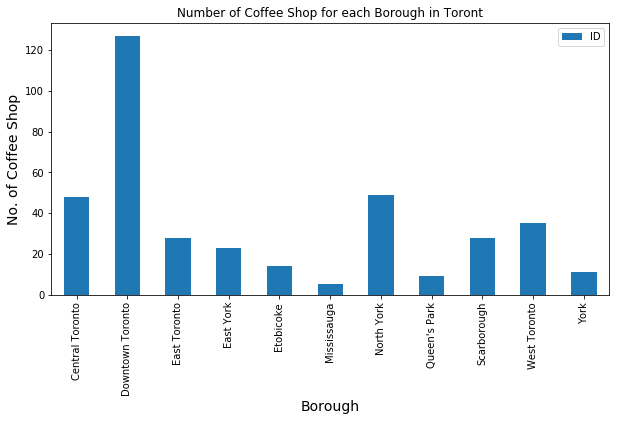

In [72]:
# Analysing the data
coffee_shop_csv.groupby('Borough')['ID'].count().plot(kind='bar', figsize=(10,5))

# tittle
plt.title('Number of Coffee Shop for each Borough in Toront')

#x-axis
plt.xlabel('Borough', fontsize = 14)

#y-axis
plt.ylabel('No. of Coffee Shop', fontsize = 14)

#Legend
plt.legend()

#Displays the bar plot
plt.show()

We see that Downtown Toronto has the largest number of Coffee Shop

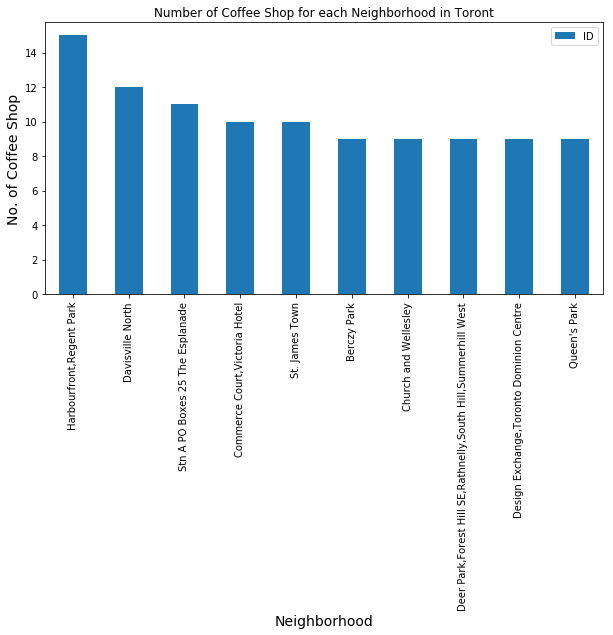

In [73]:
# Analysing the data
coffee_shop_csv.groupby('Neighborhood')['ID'].count().nlargest(10).plot(kind='bar', figsize=(10,5))

# tittle
plt.title('Number of Coffee Shop for each Neighborhood in Toront')

#x-axis
plt.xlabel('Neighborhood', fontsize = 14)

#y-axis
plt.ylabel('No. of Coffee Shop', fontsize = 14)
#Legend
plt.legend()
#Displays the bar plot
plt.show()

We see that together Harbourfront and Regent Park have the largest number of Coffee Shop.

In [75]:
coffee_shop_csv[coffee_shop_csv['Neighborhood'] == 'Davisville North']

Borough      Neighborhood                        ID  \
244  Central Toronto  Davisville North  4aec6b7df964a520e0c621e3   
245  Central Toronto  Davisville North  51819802498ee3c6834b8e0b   
246  Central Toronto  Davisville North  4ad9c161f964a520a11a21e3   
247  Central Toronto  Davisville North  4f79e8a1e4b03b459fae7e97   
248  Central Toronto  Davisville North  4b77f28ff964a520c6af2ee3   
249  Central Toronto  Davisville North  4adc5b05f964a520d52b21e3   
250  Central Toronto  Davisville North  4aec6bbaf964a520e6c621e3   
251  Central Toronto  Davisville North  4dce8fd5d164679b8d01ff13   
252  Central Toronto  Davisville North  4c0092fdad46c9b6f5cb8f66   
253  Central Toronto  Davisville North  4ae986c6f964a52003b521e3   
254  Central Toronto  Davisville North  4b62d9d0f964a5207a552ae3   
255  Central Toronto  Davisville North  4b6b2cfff964a520a6f72be3   

                                 Name  
244                         Starbucks  
245  De Mello Palheta Coffee Roasters  
246                         Starbucks  
247                         Starbucks  
248                Aroma Espresso Bar  
249                         Starbucks  
250                         Starbucks  
251                         Starbucks  
252                       Tim Hortons  
253                       Tim Hortons  
254                        Second Cup  
255                        Second Cup

The number of Coffee Shops in Davisville is 12. 

In [76]:
# prepare neighborhood list that contains Coffee Shops
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
coffee_shop_stats=pd.DataFrame(columns=column_names)
count=1


for row in coffee_shop_csv.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these Coffee Shop as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(coffee_shop),')','processed')
    coffee_shop_stats = coffee_shop_stats.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4b87107cf964a5207fae31e3
( 1 / 377 ) processed
                         ID         Name  Likes  Rating  Tips
0  4bbe904a85fbb713420d7167  Tim Hortons     21     6.4     7
( 2 / 377 ) processed
                         ID         Name  Likes  Rating  Tips
0  4b609d8df964a52068f029e3  Tim Hortons     23     6.1    13
( 3 / 377 ) processed
                         ID           Name  Likes  Rating  Tips
0  53b8466a498e83df908c3f21  Tandem Coffee     47     8.7    20
( 4 / 377 ) processed
                         ID  Name  Likes  Rating  Tips
0  57cd9d20498e6ab8342980e2  Arvo     53     9.2    10
( 5 / 377 ) processed
                         ID            Name  Likes  Rating  Tips
0  51853a73498e4d97a8b20831  Rooster Coffee    239     9.1    71
( 6 / 377 ) processed
                         ID             Name  Likes  Rating  Tips
0  5619551a498e9e35fce2256b  Sumach Espresso     18     8.7     4
( 

In [78]:
print('The shape of the dataframe is: ', coffee_shop_stats.shape)
coffee_shop_stats.head()

The shape of the dataframe is:  (377, 7)


Borough              Neighborhood                        ID  \
0        North York                 Parkwoods                         0   
1        North York          Victoria Village  4bbe904a85fbb713420d7167   
2        North York          Victoria Village  4b609d8df964a52068f029e3   
3  Downtown Toronto  Harbourfront,Regent Park  53b8466a498e83df908c3f21   
4  Downtown Toronto  Harbourfront,Regent Park  57cd9d20498e6ab8342980e2   

            Name Likes Rating Tips  
0              0     0      0    0  
1    Tim Hortons    21    6.4    7  
2    Tim Hortons    23    6.1   13  
3  Tandem Coffee    47    8.7   20  
4           Arvo    53    9.2   10

In [79]:
coffee_shop_stats.to_csv('Coffee_shops_stats.csv', index=False)

In [89]:
coffee_shop_stats_csv = pd.read_csv('Coffee_shops_stats.csv')

In [90]:
coffee_shop_stats_csv.shape

(377, 7)

In [91]:
coffee_shop_stats_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 7 columns):
Borough         377 non-null object
Neighborhood    377 non-null object
ID              377 non-null object
Name            377 non-null object
Likes           377 non-null int64
Rating          377 non-null float64
Tips            377 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 20.7+ KB


In [92]:
coffee_shop_stats_csv['Likes'] = coffee_shop_stats_csv['Likes'].astype('float')

In [93]:
coffee_shop_stats_csv['Tips'] = coffee_shop_stats_csv['Tips'].astype('float')

In [94]:
coffee_shop_stats_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 7 columns):
Borough         377 non-null object
Neighborhood    377 non-null object
ID              377 non-null object
Name            377 non-null object
Likes           377 non-null float64
Rating          377 non-null float64
Tips            377 non-null float64
dtypes: float64(3), object(4)
memory usage: 20.7+ KB


In [96]:
#Coffee shops with maximum likes
coffee_shop_stats_csv.iloc[coffee_shop_stats_csv['Likes'].idxmax()]

Borough                                Downtown Toronto
Neighborhood    Chinatown,Grange Park,Kensington Market
ID                             4ad76dadf964a520530a21e3
Name                            Dark Horse Espresso Bar
Likes                                               355
Rating                                              8.4
Tips                                                169
Name: 313, dtype: object

In [97]:
#Coffee shops with maximum Rating
coffee_shop_stats_csv.iloc[coffee_shop_stats_csv['Rating'].idxmax()]

Borough                 Downtown Toronto
Neighborhood    Harbourfront,Regent Park
ID              57cd9d20498e6ab8342980e2
Name                                Arvo
Likes                                 53
Rating                               9.2
Tips                                  10
Name: 4, dtype: object

In [98]:
#Coffee shops with maximum Tips
coffee_shop_stats_csv.iloc[coffee_shop_stats_csv['Tips'].idxmax()]

Borough                                Downtown Toronto
Neighborhood    Chinatown,Grange Park,Kensington Market
ID                             4ad76dadf964a520530a21e3
Name                            Dark Horse Espresso Bar
Likes                                               355
Rating                                              8.4
Tips                                                169
Name: 313, dtype: object

In [115]:
neibor_stats_rating = coffee_shop_stats_csv.groupby('Neighborhood', as_index=False).mean()[['Neighborhood','Rating']]
neibor_stats_rating.columns=['Neighborhood','Average Rating']

In [123]:
neibor_stats_rating.sort_values(['Average Rating'], ascending=False).head(15)


Neighborhood  Average Rating
43                      Harbord,University of Toronto        8.900000
18            Chinatown,Grange Park,Kensington Market        8.633333
45                           Harbourfront,Regent Park        8.420000
71                                     St. James Town        8.370000
7                                         Berczy Park        8.355556
72                    Stn A PO Boxes 25 The Esplanade        8.290909
59                                 North Toronto West        8.266667
69                            Ryerson,Garden District        8.257143
0                              Adelaide,King,Richmond        8.257143
12  CN Tower,Bathurst Quay,Island airport,Harbourf...        8.250000
64                                       Queen's Park        8.211111
38              First Canadian Place,Underground city        8.200000
13                         Cabbagetown,St. James Town        8.200000
55                            Little Portugal,Trinity        8.200000
23                      Commerce Court,Victoria Hotel        8.190000

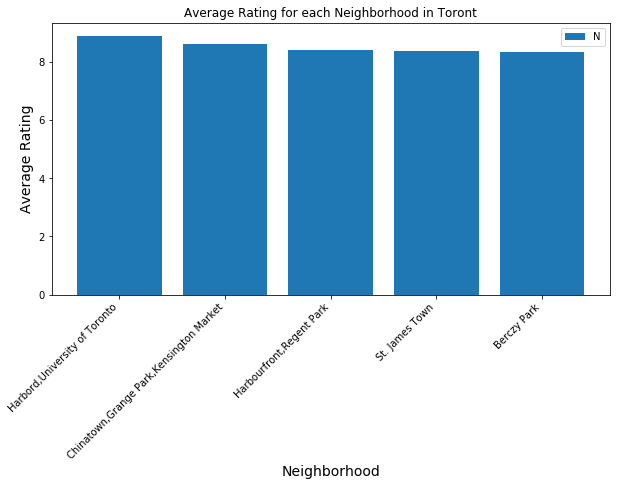

In [141]:
# Analysing the data
neighborhood = neibor_stats_rating.loc[[43,18,45,71,7],'Neighborhood']
avarege_ratings = neibor_stats_rating.loc[[43,18,45,71,7],'Average Rating']
plt.figure(figsize=(10,5))
plt.bar(neighborhood, avarege_ratings)

# tittle
plt.title('Average Rating for each Neighborhood in Toront')

#x-axis
plt.xlabel('Neighborhood', fontsize =14)
plt.xticks(rotation=45, horizontalalignment='right')

#y-axis
plt.ylabel('Average Rating', fontsize = 14)
#Legend
plt.legend('Neighborhood')
#Displays the bar plot
plt.show()

In [104]:
borough_stats_rating = coffee_shop_stats_csv.groupby('Borough', as_index=False).mean()[['Borough','Rating']]
borough_stats_rating.columns=['Borough','Average Rating']

In [105]:
borough_stats_rating.sort_values(['Average Rating'], ascending=False).head(15)

Borough  Average Rating
7       Queen's Park        8.211111
1   Downtown Toronto        8.185827
9       West Toronto        7.254286
2       East Toronto        7.064286
0    Central Toronto        6.981250
4          Etobicoke        6.221429
3          East York        6.165217
5        Mississauga        6.080000
8        Scarborough        5.692857
6         North York        5.608163
10              York        5.454545

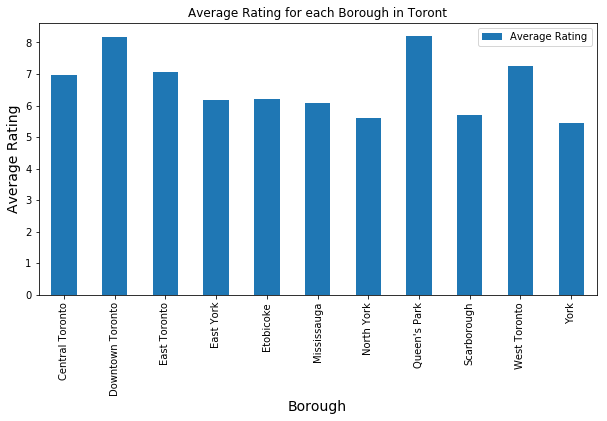

In [111]:
# Analysing the data
neibor_stats_rating.groupby('Borough').mean()['Average Rating'].plot(kind='bar', figsize=(10,5))
#plt.figure(figsize=(9,5), dpi = 100)

# tittle
plt.title('Average Rating for each Borough in Toront')

#x-axis
plt.xlabel('Borough', fontsize = 14)

#y-axis
plt.ylabel('Average Rating', fontsize = 14)
#Legend
plt.legend()
#Displays the bar plot
plt.show()

And like the neighborhood analysis, we came to the conclusion that Queen's Park and Downtown Toronto have the same average rating, so the two districts are tied for the best borough position.

In [142]:
neibor_stats_rating = neibor_stats_rating[neibor_stats_rating['Average Rating'] >= 8.0]

In [143]:
neibor_stats_rating

Neighborhood  Average Rating
0                              Adelaide,King,Richmond        8.257143
7                                         Berczy Park        8.355556
12  CN Tower,Bathurst Quay,Island airport,Harbourf...        8.250000
13                         Cabbagetown,St. James Town        8.200000
17                                 Central Bay Street        8.171429
18            Chinatown,Grange Park,Kensington Market        8.633333
20                               Church and Wellesley        8.122222
23                      Commerce Court,Victoria Hotel        8.190000
28            Design Exchange,Toronto Dominion Centre        8.166667
38              First Canadian Place,Underground city        8.200000
43                      Harbord,University of Toronto        8.900000
45                           Harbourfront,Regent Park        8.420000
55                            Little Portugal,Trinity        8.200000
59                                 North Toronto West        8.266667
64                                       Queen's Park        8.211111
69                            Ryerson,Garden District        8.257143
71                                     St. James Town        8.370000
72                    Stn A PO Boxes 25 The Esplanade        8.290909
73                                    Studio District        8.171429

In [144]:
neibor_stats_rating = pd.merge(neibor_stats_rating, Toronto_df, on='Neighborhood')

In [145]:
neibor_stats_rating

Neighborhood  Average Rating  \
0                              Adelaide,King,Richmond        8.257143   
1                                         Berczy Park        8.355556   
2   CN Tower,Bathurst Quay,Island airport,Harbourf...        8.250000   
3                          Cabbagetown,St. James Town        8.200000   
4                                  Central Bay Street        8.171429   
5             Chinatown,Grange Park,Kensington Market        8.633333   
6                                Church and Wellesley        8.122222   
7                       Commerce Court,Victoria Hotel        8.190000   
8             Design Exchange,Toronto Dominion Centre        8.166667   
9               First Canadian Place,Underground city        8.200000   
10                      Harbord,University of Toronto        8.900000   
11                           Harbourfront,Regent Park        8.420000   
12                            Little Portugal,Trinity        8.200000   
13                                 North Toronto West        8.266667   
14                                       Queen's Park        8.211111   
15                            Ryerson,Garden District        8.257143   
16                                     St. James Town        8.370000   
17                    Stn A PO Boxes 25 The Esplanade        8.290909   
18                                    Studio District        8.171429   

             Borough   Latitude  Longitude  
0   Downtown Toronto  43.650571 -79.384568  
1   Downtown Toronto  43.644771 -79.373306  
2   Downtown Toronto  43.628947 -79.394420  
3   Downtown Toronto  43.667967 -79.367675  
4   Downtown Toronto  43.657952 -79.387383  
5   Downtown Toronto  43.653206 -79.400049  
6   Downtown Toronto  43.665860 -79.383160  
7   Downtown Toronto  43.648198 -79.379817  
8   Downtown Toronto  43.647177 -79.381576  
9   Downtown Toronto  43.648429 -79.382280  
10  Downtown Toronto  43.662696 -79.400049  
11  Downtown Toronto  43.654260 -79.360636  
12      West Toronto  43.647927 -79.419750  
13   Central Toronto  43.715383 -79.405678  
14      Queen's Park  43.662301 -79.389494  
15  Downtown Toronto  43.657162 -79.378937  
16  Downtown Toronto  43.651494 -79.375418  
17  Downtown Toronto  43.646435 -79.374846  
18      East Toronto  43.659526 -79.340923

Now we will show this data on a map.

In [162]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
latitude_toronto = location.latitude
longitude_toronto = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude_toronto, longitude_toronto))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [189]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# add markers to map
for lat, lng, label in zip(neibor_stats_rating['Latitude'], neibor_stats_rating['Longitude'], neibor_stats_rating['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='brown',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

This map shows the Coffee Shops in each neighborhood with an average rating above 8.0 in Toronto.

In [188]:
from folium import plugins #import package 

map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=12)
incidents = plugins.MarkerCluster().add_to(map_toronto)

for lat, lng, label in zip(neibor_stats_rating['Latitude'], neibor_stats_rating['Longitude'], neibor_stats_rating['Neighborhood']):
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=7, # define how big you want the circle markers to be
    popup=label,
    color='brown',
    fill=True,
    fill_color='blue',
    fill_opacity=0.6,
    parse_html=False).add_to(incidents)
    
map_toronto

Now let's build a map with the Boroughs.

In [190]:
borough_stats_rating = pd.merge(borough_stats_rating, Toronto_df, on='Borough') #merging the average rating with the coordinates of the boroughs

In [193]:
from folium import plugins #import package 

map_toronto_2 = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=10)
incidents = plugins.MarkerCluster().add_to(map_toronto_2)

for lat, lng, label in zip(borough_stats_rating['Latitude'], borough_stats_rating['Longitude'], borough_stats_rating['Borough']):
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=7, # define how big you want the circle markers to be
    popup=label,
    color='red',
    fill=True,
    fill_color='blue',
    fill_opacity=0.6,
    parse_html=False).add_to(incidents)
    
map_toronto_2

In [230]:
# download countries geojson file

!wget --quiet https://raw.githubusercontent.com/jasonicarter/toronto-geojson/master/toronto_crs84.geojson -o toronto.json

print('GeoJSON file downloaded!')


GeoJSON file downloaded!


In [263]:
#GeoJSON file
toronto_geo = requests.get('https://raw.githubusercontent.com/jasonicarter/toronto-geojson/master/toronto_crs84.geojson').json()

# create a plain world map
toronto_map = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=9)


In [267]:
# generate choropleth map using Average rating from each Borough
toronto_map.choropleth(
    geo_data=toronto_geo,
    data=borough_stats_rating,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating',
    highlight=True
)

# display map
toronto_map.save('borough_rating_toronto.html')
toronto_map

We can't see the map because the map data is huge. Then we will save the map for future viewing.

### Conclusion 

* After all the analysis, we can now answer the questions from stakeholders.

**1 - What is the best location in Toronto for have a coffee?**

*The Adelaide, King, Richmond and Berczy Park are some of the best neighborhoods for have a coffee in Toronto.*

**2 - Which areas have potential Coffee Shop Market?** 

*Queen’s Park is the best borough for have a coffee. The average rating for this borough is around 8.21.*

**3 - Which areas lack Coffee Shops?**

*The area that lacks good Coffee Shops is York with an average rating of 5.45.*

**4 - Which is the best borough to stay if I want have a coffee?**

*For this matter, we need to do additional analysis that encompasses other features to make a better decision. These analyzes are complementary goals for this project. But answering the question with the data in hand, the best neighborhood is the one with the highest average rating, hence Queen's park.*

**5 - Which is the best Coffee Shop in Toronto?**

*This question we will answer based on maximum likes, hence Dark Horse Espresso Bar.*

**6 - Which Coffee Shop is rated highest in Toronto?**

*The Coffee Shop in Toronto with the highest rating is Arvo.*